In [65]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, tnrange

## PyTorch Overview:

PyTorch is a deep learning framework for fast, flexible experimentation.

PyTorch consists of 4 main packages:

- torch: a general purpose array library similar to Numpy that can do computations on GPU when the tensor type is cast to (torch.cuda.TensorFloat)
- torch.autograd: a package for building a computational graph and automatically obtaining gradients
- torch.nn: a neural net library with common layers and cost functions
- torch.optim: an optimization package with common optimization algorithms like SGD, Adam, etc

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Get Data

### Dataset

MNIST dataset is part of PyTorch and can be downloaded. We'll learn to create custom datasets later. A dataset in Pytorch is a subclass of torch.utils.data.Dataset thas has methods \__getitem__ and \__len__ methods implemented.

In [4]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

Processing...
Done!


In [6]:
# train_ds[0] is a tuple with an image (x) and a class (y)
x, y = train_ds[0]
print(x.shape)

torch.Size([1, 28, 28])


### DataLoader

Data loader combines a dataset and a sampler, and provides an iterator over the dataset. The data loader divides the data in mini batches. This is particularly important when working with large dataset that cannot be hold in memory.

In [7]:
batch_size = 64
# Train data should be shuffled between epochs
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# for test we use shuffle=False
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

**How does a batch look like?**

In [8]:
train_dl = iter(train_loader)
x, y = next(train_dl)
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

**What's in the tensors?**

In [9]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

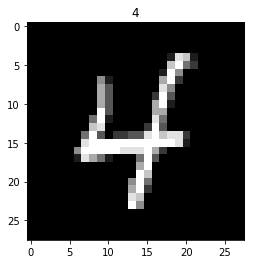

In [11]:
X = x.numpy()
Y = y.numpy()
show(X[1][0], Y[1])

## Create a Layer

In [26]:
# Linear layer (characteristic of feed forward networks), transforms n*D data into n*M where,
# n is the number of observations
# D is the number of features
# M is the number of transformed features
D = 5
M = 3
lin_layer = nn.Linear(D, M)

When a layer is intantiated, parameters of the layer (weights and biases) are randomly initialized

In [19]:
[p for p in lin_layer.parameters()]

[Parameter containing:
 tensor([[ 0.4358, -0.3806, -0.2367,  0.4000,  0.1718],
         [ 0.3792, -0.3616, -0.2295, -0.1537, -0.1973],
         [-0.0468,  0.1025, -0.2533,  0.3260, -0.3701]]), Parameter containing:
 tensor([-0.2213, -0.1573, -0.4115])]

In [23]:
n = 10
# Create random input
A = torch.randn(n, D)
A

tensor([[ 0.8302,  0.3401,  0.2838, -0.0232,  0.9266],
        [ 0.6903, -0.9846, -1.6355, -1.1105,  3.0589],
        [ 0.5845,  0.1767,  1.4728,  0.7216, -0.8400],
        [ 1.7570,  0.4217, -0.4522,  0.2240, -1.6039],
        [ 1.9590, -0.4269,  0.4313,  1.3806,  1.4492],
        [ 0.3536,  1.5563, -1.6681, -0.8075, -1.2534],
        [ 1.3373, -1.3712, -2.6185, -1.4181, -0.4229],
        [-0.1159, -1.7881, -0.8945,  1.6791, -1.4910],
        [ 0.3747,  1.8120,  1.3073,  1.1465, -0.1520],
        [ 0.8568,  0.0198,  1.5436,  0.7328, -0.2708]])

In [24]:
lin_layer(A)

tensor([[ 0.0938, -0.2098, -0.8379],
        [ 0.9228,  0.4032, -1.6244],
        [-0.2382, -0.2828, -0.2478],
        [ 0.3049,  0.7422,  0.3305],
        [ 1.4941,  0.1428, -0.7425],
        [-0.8030,  0.1683,  0.3546],
        [ 0.8634,  1.7480, -0.2571],
        [ 1.0359,  0.6865,  0.7365],
        [-0.6246, -1.1167, -0.1446],
        [ 0.0257, -0.2531, -0.5016]])

## Create a Model

### nn.Sequential

To create a model with nn.Sequential you provide a list of layers. For example, the following model defines a 2-layer neural network with $784$ input features ($D = 784$), $300$ hidden layers ($M=300$) and $10$ outputs. This model uses Relu activation funtion and no final activation.

In [25]:
net = nn.Sequential(nn.Linear(784, 300),
                    nn.ReLU(),
                    nn.Linear(300, 10))

### nn.Module

A more flexible way to define models in pytorch is as a subclass of nn.Module. In the __init__ method we define all layers that will be used later. In the forward method, we define the actual model using the already defined layers.

In [27]:
class Net(nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
        self.linear1 = nn.Linear(784, 300)
        self.linear2 = nn.Linear(300, 10)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

net = Net()

In [28]:
# this line prints all parameters
# [p for p in net.parameters()]

### optim (Optimizer)

torch.optim provides implementations of commonly used optimization algorithms (such us gradient descent and momentum). You need to specify the algorithm you want to use. Adam is a popular algorithm. You also specify the parameters you want to optimize and the learning rate. If you want to use $L_2$ regularization you can specify the weight decay.

In [29]:
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

### Training Loop

Each epoch of the training has to go through entire dataset (multiple mini-batches) also called forward pass and gradients should be propogated backwards (BackProp). The purpose of the training loop is to set model to train and process the data using dataloaders created and update the parameters.

In [51]:
def train_model(train_loader, model, optimizer):
    # set model to training state
    model.train()
    sum_loss = 0.0 # Initialize loss to zero
    total_samples = 0 # Initialize data processed by the model to zero
    
    for images, labels in train_loader:
        batch = images.shape[0] # size of the batch
        images = images.view(-1, 28*28) # flattening the images
        pred = model(images) # forward pass, make predictins
        loss = F.cross_entropy(pred, labels) # compute loss
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # backprop gradients
        optimizer.step() # update parameters
        sum_loss += batch * loss.item() # not all batches are of same size
        total_samples += batch
    
    train_loss = sum_loss/total_samples # compute mean loss
    return train_loss

### Model Evaluation

Given a model and data (in the form of a dataloader), we evaluate the model performance.

In [35]:
def model_eval(model, data_loader):
    model.eval() # set the model to evaluation mode
    correct = 0 # Initialize correct predictions 
    sum_loss = 0.0 # Initialize total loss
    total = 0 # Initialize samples processed by the model to zero
    for images, labels in data_loader:
        batch = labels.size(0) # Equivalent to labels.shape[0]
        images = images.view(-1, 28*28)
        pred = model(images)
        loss = F.cross_entropy(pred, labels)
        sum_loss += batch*loss.item()
        total += batch
        _, pred = torch.max(pred.data, 1) # computes a hard prediction
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

## Training the Model

In [52]:
net = Net()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.0)

In [53]:
epochs = 10
for i in tnrange(epochs, desc='Epoch'):
    train_loss = train_model(train_loader, net, optimizer)
    print("train loss ", train_loss)
    acc, loss = model_eval(net, test_loader)
    print("accuracy and test loss ", acc, loss)

train loss  0.28557449571192267
accuracy and test loss  93.91 0.23288310603946447
train loss  0.21190326106796661
accuracy and test loss  91.75 0.3497096668928862
train loss  0.19250318566312394
accuracy and test loss  94.52 0.2249447972588241
train loss  0.1797704157114029
accuracy and test loss  94.59 0.25306223648935555
train loss  0.17958513912657897
accuracy and test loss  94.92 0.22026115838708357
train loss  0.16937018661759795
accuracy and test loss  95.48 0.24710467757806182
train loss  0.16845348128850263
accuracy and test loss  94.97 0.2388424200611189
train loss  0.15729533572234214
accuracy and test loss  95.74 0.2231523359847488
train loss  0.15582410916984082
accuracy and test loss  95.36 0.26285289277319096
train loss  0.15476816681635877
accuracy and test loss  95.47 0.2608021271620528


### Create 3 layer network and decrease learning rate after 5 epochs

In [62]:
class Net3Layer(nn.Module):
    def __init__(self):
        super(Net3Layer, self).__init__()
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 250)
        self.layer3 = nn.Linear(250,10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        
        return x

In [63]:
net3L = Net3Layer()
learning_rate = 0.01
optimizer3L = optim.Adam(net3L.parameters(), lr=learning_rate)

In [67]:
n_epochs = 10
for i in tnrange(n_epochs, desc='Epoch'):
    if i==5:
        for p in optimizer3L.param_groups:
            p['lr'] = 0.001
    train_loss = train_model(train_loader, net3L, optimizer3L)
    tqdm.write(f'Train loss: {train_loss:{.4}}')
    acc, test_loss = model_eval(net3L, test_loader)
    tqdm.write(f'Test accuracy: {acc:{2.4}} and loss: {test_loss:{.4}}')

Train loss: 0.1738
Test accuracy: 95.1 and loss: 0.2096
Train loss: 0.1612
Test accuracy: 95.85 and loss: 0.1998
Train loss: 0.148
Test accuracy: 95.21 and loss: 0.2539
Train loss: 0.149
Test accuracy: 95.82 and loss: 0.1999
Train loss: 0.1451
Test accuracy: 96.32 and loss: 0.2002
Train loss: 0.07873
Test accuracy: 97.23 and loss: 0.1305
Train loss: 0.0601
Test accuracy: 97.31 and loss: 0.1313
Train loss: 0.05337
Test accuracy: 97.36 and loss: 0.1285
Train loss: 0.04829
Test accuracy: 97.29 and loss: 0.1329
Train loss: 0.04465
Test accuracy: 97.28 and loss: 0.135
